# ECoG

In [11]:
#@title Data retrieval
import os, requests

fname = 'memory_nback.npz'
url = "https://osf.io/xfc7e/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [12]:
#@title Install packages, import matplotlib and set defaults
# install packages to visualize brains and electrode locations
!pip install nilearn --quiet
!pip install nimare --quiet

from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [13]:
#@title Data loading
import numpy as np
import pandas as pd

alldat = np.load(fname, allow_pickle=True)['dat']

# Select just one of the recordings here. This is subject 1, block 1.
dat = alldat[1][1]
dat1 = alldat[0][1]
dat3 = alldat[2][1]

print(dat.keys())

all = np.concatenate((dat1['locs'], dat['locs'], dat3['locs']))

dict_keys(['V', 't_off', 'locs', 'srate', 'scale_uv', 't_on', 'target', 'stim_id', 'response', 'rt', 'expinfo'])


## Visualization

In [14]:
from nilearn import plotting  
from nimare import utils

colours = np.empty(64*3, dtype=str)
colours[:64] = "green"
colours[64:128] = 'red'
colours[128:] = 'blue'

#print(colours)

plt.figure(figsize=(14,14))
locs = all #dat['locs']
view = plotting.view_markers(utils.tal2mni(locs), marker_labels  = ['%d'%k for k in np.arange(locs.shape[0])], marker_color = colours, marker_size=2)
view

ERROR:duecredit:Failed to import duecredit due to No module named 'duecredit'


<Figure size 1008x1008 with 0 Axes>

## Power Spectrum

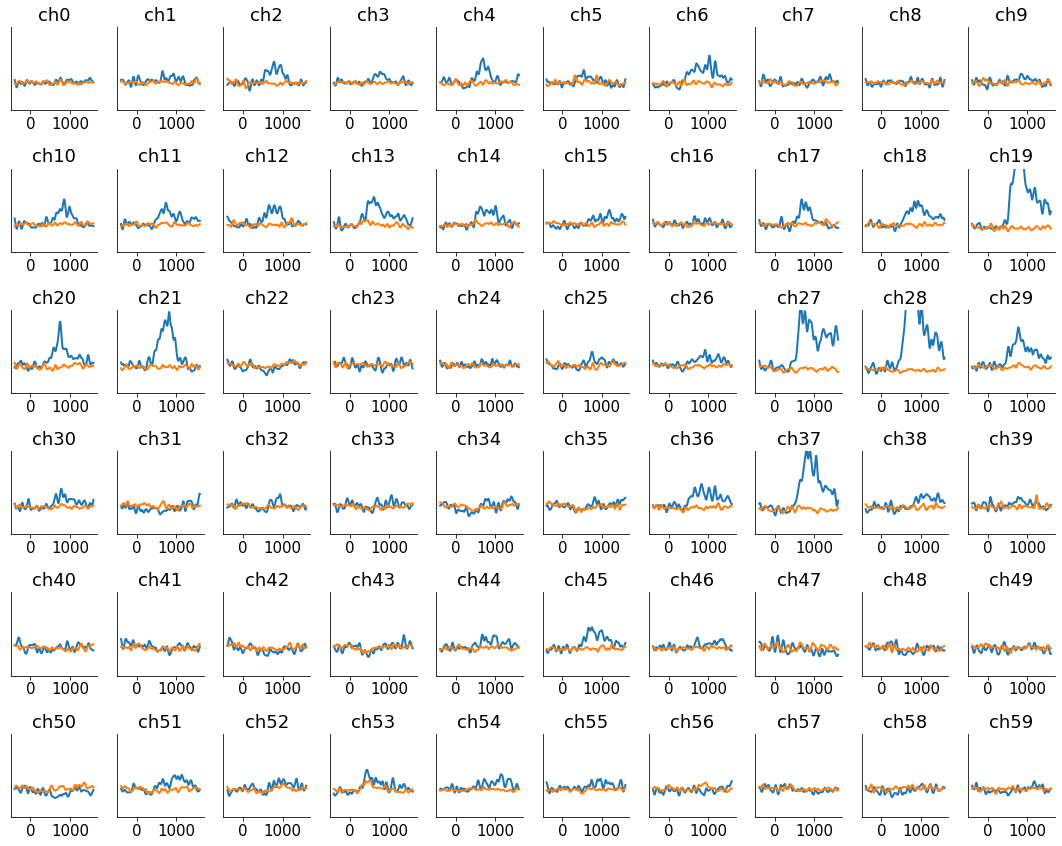

In [15]:
# compute spectral power above 50Hz and low-pass below 10Hz
# power is always positive, so we normalize it by its average
from scipy import signal

# pick subject 1 and experiment 1 
dat = alldat[1][1]
V = dat['V'].astype('float32') # always convert the voltage data to float32!

# high-pass filter above 50 Hz
b, a = signal.butter(3, [50], btype = 'high', fs=1000)
V = signal.filtfilt(b,a,V,0)

# compute smooth envelope of this signal = approx power
V = np.abs(V)**2
b, a = signal.butter(3, [10], btype = 'low', fs=1000)
V = signal.filtfilt(b,a,V,0)

# normalize each channel so its mean power is 1
V = V/V.mean(0)

# divide into trials and average

nt, nchan = V.shape
nstim = len(dat['t_on'])

# use a timerange from 400ms before to 1600ms after the stimulus onset
trange = np.arange(-400, 1600)
ts = dat['t_on'][:,np.newaxis] + trange
V_epochs = np.reshape(V[ts, :], (nstim, 2000, nchan))

V_resp = (V_epochs[dat['response']==1]).mean(0)
V_base  = (V_epochs[dat['response']==0]).mean(0)

# let's find the electrodes that distinguish responses from non-responses
# note these are event-related potentials
from matplotlib import pyplot as plt

plt.figure(figsize=(15,12))
for j in range(60):
  ax = plt.subplot(6,10,j+1)
  plt.plot(trange, V_resp[:,j], lw=2)
  plt.plot(trange, V_base[:,j], lw=2)
  plt.title('ch%d'%j)
  plt.yticks([])
  plt.ylim([0, 3])